In [1]:
# Encoder-Decoder结构的思想
# encoder将一个句子的信息压缩成一个向量  decoder利用向量来进行预测

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras
import unicodedata
import re
from sklearn.model_selection import train_test_split

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.6.4
sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.6.4
keras.api._v2.keras 2.6.0


In [3]:
# unicode转换成ascii 去除西班牙语中的一些特殊字符
def unicode_to_ascii(s):
    # 转换方法NFD 将每一个字符拆开 去除重音Mn
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')


# 测试
en_sequence = u'May I borrow this book?'
sp_sequence = u'¿Puedo tomar prestado este libro?'
print(unicode_to_ascii(en_sequence))
print(unicode_to_ascii(sp_sequence))


def preprocess_sentence(w: str):
    # 变为小写并去掉多余空格
    w = unicode_to_ascii((w.lower().strip()))
    # 替换 标点符号前后添加空格
    w = re.sub(r'([?.!,¿])', r' \1 ', w)
    # 连续空格处理
    w = re.sub(r'[" "]+', ' ', w)
    # 将除a-zA-Z?.!,¿的所有字符替换成空格
    w = re.sub(r'[^a-zA-Z?.!,¿]+', ' ', w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    # 在句子中添加开始和结束标记，以便模型知道何时开始和停止预测
    return w


print(preprocess_sentence(en_sequence))
print(preprocess_sentence(sp_sequence))
print(preprocess_sentence(sp_sequence).encode('utf_8'))

May I borrow this book?
¿Puedo tomar prestado este libro?
<start> may i borrow this book ? <end>
<start> ¿ puedo tomar prestado este libro ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [4]:
data_path = '../input/spatxt/spa.txt'


def create_dataset(path, num_examples):
    lines = open(path, encoding='utf-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]  # [ENGLISH, SPANISH]
    return zip(*word_pairs)


en, sp = create_dataset(data_path, 30000)
print(type(en))
print(type(sp))
print(len(en))
print(en[-1])
print(sp[-1])

<class 'tuple'>
<class 'tuple'>
30000
<start> we ll see you at . <end>
<start> te veremos a las dos y media . <end>


In [5]:
def max_length(tensor):
    return max(len(t) for t in tensor)


def tokenize(language):
    # 生成对应词语index  filters过滤
    language_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    language_tokenizer.fit_on_texts(language)  # 提取
    tensor = language_tokenizer.texts_to_sequences(language)  # 单词换为id
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, language_tokenizer


def load_dataset(path, num_examples=None):
    target_language, input_language = create_dataset(path, num_examples)
    input_tensor, input_language_tokenizer = tokenize(input_language)
    target_tensor, target_language_tokenizer = tokenize(target_language)
    return input_tensor, target_tensor, input_language_tokenizer, target_language_tokenizer


num_examples = 30000
input_tensor, target_tensor, input_language_tokenizer, target_language_tokenizer\
    = load_dataset(data_path, num_examples)

In [6]:
print(target_language_tokenizer.word_index['<start>'])
print(target_language_tokenizer.word_index['<end>'])
print(target_language_tokenizer.index_word[1])
print(target_language_tokenizer.index_word[2])
print(target_language_tokenizer.index_word[666])
print(input_language_tokenizer.index_word[55])
print(input_language_tokenizer.word_index['frio'])

1
2
<start>
<end>
finish
fue
228


In [7]:
print(input_tensor.shape, target_tensor.shape, input_language_tokenizer, target_language_tokenizer)
print('-' * 50)
print(input_tensor[0])
print(target_tensor[0])
print('-' * 50)
print(input_tensor[29999])
print(target_tensor[29999])
print('-' * 50)
# 最大样本长度
target_max_length, input_max_length = max_length(target_tensor), max_length(input_tensor)
print(input_max_length, target_max_length)

(30000, 16) (30000, 11) <keras_preprocessing.text.Tokenizer object at 0x7f09e52d8610> <keras_preprocessing.text.Tokenizer object at 0x7f09e2eaefd0>
--------------------------------------------------
[  1 135   3   2   0   0   0   0   0   0   0   0   0   0   0   0]
[ 1 36  3  2  0  0  0  0  0  0  0]
--------------------------------------------------
[   1   23 2175   10   39   98   87  314    3    2    0    0    0    0
    0    0]
[ 1 16 38 72  6 55  3  2  0  0  0]
--------------------------------------------------
16 11


In [8]:
# 分训练集和验证集
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val\
    = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=1)
print(len(input_tensor_train), len(input_tensor_val))
print(len(target_tensor_train), len(target_tensor_val))

24000 6000
24000 6000


In [9]:
# 通过index看原单词
def convert(tokenizer, tensor):
    for t in tensor:
        if t != 0:
            print(f'{t}-->{tokenizer.index_word[t]}-->{len(tokenizer.index_word[t])}')


print("Input Language; index to word mapping")
convert(input_language_tokenizer, input_tensor_train[0])
print('-' * 50)
print("Target Language; index to word mapping")
convert(target_language_tokenizer, target_tensor_train[0])

Input Language; index to word mapping
1--><start>-->7
53-->quiero-->6
72-->ir-->2
269-->contigo-->7
3-->.-->1
2--><end>-->5
--------------------------------------------------
Target Language; index to word mapping
1--><start>-->7
4-->i-->1
47-->want-->4
15-->to-->2
36-->go-->2
80-->with-->4
6-->you-->3
3-->.-->1
2--><end>-->5


In [10]:
BUFFERSIZE = len(input_tensor_train)
BATCHSIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCHSIZE
embedding_dim = 256
units = 1024
# +1是新用0进行了填充
input_vocab_size = len(input_language_tokenizer.word_index) + 1
print('input_vocab_size:', input_vocab_size)
target_vocab_size = len(target_language_tokenizer.word_index) + 1
print('target_vocab_size:', target_vocab_size)
# 训练集
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFERSIZE)
dataset = dataset.batch(BATCHSIZE, drop_remainder=True)
print(dataset)

input_vocab_size: 9414
target_vocab_size: 4935


2022-08-06 06:38:34.031806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 06:38:34.042252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 06:38:34.043002: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 06:38:34.044424: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

<BatchDataset shapes: ((64, 16), (64, 11)), types: (tf.int32, tf.int32)>


In [11]:
example_input_batch, example_target_batch = next(iter(dataset))
print(example_input_batch)
print('-' * 50)
print(example_target_batch)
print('-' * 50)

tf.Tensor(
[[   1 7664   11 ...    0    0    0]
 [   1   13 7056 ...    0    0    0]
 [   1   24   14 ...    0    0    0]
 ...
 [   1    6  646 ...    0    0    0]
 [   1    8   69 ...    0    0    0]
 [   1 1040 3978 ...    0    0    0]], shape=(64, 16), dtype=int32)
--------------------------------------------------
tf.Tensor(
[[   1    4 4115   15   93    3    2    0    0    0    0]
 [   1   68 3877    8  141    3    2    0    0    0    0]
 [   1    4   18   91    3    2    0    0    0    0    0]
 [   1  254   24   21 1906    3    2    0    0    0    0]
 [   1  205   91   49   56    3    2    0    0    0    0]
 [   1   16 1547    5    3    2    0    0    0    0    0]
 [   1   30   12   73    5    3    2    0    0    0    0]
 [   1  207  162  258    3    2    0    0    0    0    0]
 [   1    5    8   78 1240    3    2    0    0    0    0]
 [   1    8   20   32   14  180    7    2    0    0    0]
 [   1   30   12  802  662   10    3    2    0    0    0]
 [   1    5  106  105  239    3

In [12]:
# 搭建encoder
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, encoding_units, batch_size):
        super(Encoder, self).__init__()
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        # 编码单元
        self.encoding_units = encoding_units
        # 创建Embedding层
        self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = keras.layers.GRU(self.encoding_units,  # 输出空间的维度
                                    return_sequences=True,
                                    return_state=True,  # 拿到最后一个单词的状态输出
                                    recurrent_initializer='glorot_uniform')

    def call(self, x, hidden_state):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden_state)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoding_units))  # 初始状态尺寸固定


encoder = Encoder(input_vocab_size, embedding_dim, units, BATCHSIZE)
# 获取初始化的hidden_state
sample_hidden_state_init = encoder.initialize_hidden_state()
# 获取输出和隐含状态
sample_out, sample_hidden_state = encoder(example_input_batch, sample_hidden_state_init)
print(f'Encoder output shape: (batch size, sequence length, units) {sample_out.shape}')  # 注意return_sequences=True
print(f'Encoder Hidden state shape: (batch size, units) {sample_hidden_state.shape}')  # 注意return_state=True

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


2022-08-06 06:38:35.585117: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [13]:
print(encoder.variables)

[<tf.Variable 'encoder/embedding/embeddings:0' shape=(9414, 256) dtype=float32, numpy=
array([[ 0.02479453, -0.00656884,  0.03070227, ..., -0.00421714,
        -0.01283332, -0.00456945],
       [ 0.01489869, -0.01955741,  0.04307946, ...,  0.00624095,
         0.02940681, -0.02672064],
       [ 0.02062241,  0.00179011, -0.0182432 , ..., -0.0400409 ,
         0.03043202,  0.02011161],
       ...,
       [ 0.03835589, -0.02317623, -0.02383479, ...,  0.00942641,
         0.04622019, -0.02529624],
       [-0.00346304,  0.02111051, -0.01528226, ..., -0.04228038,
         0.01410631,  0.02722896],
       [-0.02324914,  0.01997249, -0.00810594, ...,  0.01325066,
        -0.01930857,  0.0226344 ]], dtype=float32)>, <tf.Variable 'encoder/gru/gru_cell/kernel:0' shape=(256, 3072) dtype=float32, numpy=
array([[-0.00604244,  0.01577269, -0.03123333, ...,  0.03556404,
        -0.01036665,  0.03502395],
       [ 0.02018598,  0.00340389,  0.03885472, ..., -0.00451618,
        -0.03184653,  0.01470157]

In [14]:
# 计算BahdanauAttention  score = FC(tanh(FC(EO) + FC(H))
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        # 三个全连接层
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    # query是decoder_hidden_state  values是EO(encoder_outputs)
    def call(self, query, values):
        # deocoder_hidden_shape: (batch_size, units)
        # encoder_outputs.shape: (batch_size, length, units)
        # 维度拓展
        # hidden_state shape == (batch_size, hidden_size) hidden_size实际就是decoder的units
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(query, 1)
        # 全连接层只处理最后一维
        # beforeV:(batch_ size, length, units)
        # afterV:(batch_ size, length, 1)
        # score shape == (batch_size, max_length, 1)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
        # attention_weights shape==(batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        # context_vector shape==(batch_size, length, units)
        context_vector = attention_weights * values
        # print(context_vector)
        # (batch_size, length, units)-->(batch_size, hidden_size)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [15]:
# 测试BahdanauAttention
attention_layer = BahdanauAttention(10)
# 还未搭建decoder没有decoder_hidden_state  先用形状相同的encoder的sample_hidden
attention_result, attention_weights = attention_layer(sample_hidden_state, sample_out)
print(f"Attention result shape: (batch size, units) {attention_result.shape}")
print(f"Attention weights shape: (batch_size, sequence_length, 1) {attention_weights.shape}")
print(attention_layer.variables)

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)
[<tf.Variable 'bahdanau_attention/dense/kernel:0' shape=(1024, 10) dtype=float32, numpy=
array([[-0.05452409,  0.03634037, -0.01941674, ..., -0.01416415,
        -0.04115767, -0.02246584],
       [ 0.01561897, -0.06676763, -0.0159099 , ...,  0.03151598,
        -0.05833726,  0.04790556],
       [-0.0655017 , -0.01814462,  0.01244057, ..., -0.02355582,
         0.05131865,  0.00124213],
       ...,
       [ 0.07461359,  0.07066715,  0.0401039 , ...,  0.0129366 ,
        -0.03237152,  0.05134384],
       [ 0.03092721,  0.06394853, -0.03966588, ...,  0.06963676,
        -0.01282787,  0.03146627],
       [-0.04731143,  0.04295183,  0.0393362 , ...,  0.01422859,
         0.01739714, -0.00439756]], dtype=float32)>, <tf.Variable 'bahdanau_attention/dense/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variabl

In [16]:
# 搭建decoder
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, decoding_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = keras.layers.GRU(self.decoding_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
        self.fc = keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.decoding_units)

    def call(self, x, hidden_state, encoding_output):
        # context_vector shape == (batch_size, units）
        # encoding_output shape == (batch_size, max_length, hidden_size)
        content_vector, attention_weights = self.attention(hidden_state, encoding_output)
        x = self.embedding(x)  # (batch_size, 1, target_vocab_size)-->(batch size, 1, embedding units)
        # print(content_vector.shape,x.shape)
        x = tf.concat([tf.expand_dims(content_vector, 1), x], axis=-1)  # (batch_size, 1, embedding_dim+hidden_size)
        # print(x.shape)
        output, state = self.gru(x)
        # output shape:[batch_size, 1, decoding_units]
        # state shape:[batch_size, decoding_units]
        # print(output.shape, state.shape)
        output = tf.reshape(output, (-1, output.shape[2]))  # (batch_size * 1, hidden_size)
        x = self.fc(output)  # (batch_size, target_vocab_size)
        return x, state, attention_weights


decoder = Decoder(target_vocab_size, embedding_dim, units, BATCHSIZE)
sample_decoder_output, sample_decoder_hidden_state, sample_decoder_attention_weights\
    = decoder(tf.random.uniform((BATCHSIZE, 1)), sample_hidden_state, sample_out)
print(f'Decoder output shape: (batch_size, vocab size) {sample_decoder_output.shape}')
print(f'Decoder_hidden_state shape: {sample_decoder_hidden_state.shape}')
print(f'Decoder_attention_weights shape: {sample_decoder_attention_weights.shape}')

Decoder output shape: (batch_size, vocab size) (64, 4935)
Decoder_hidden_state shape: (64, 1024)
Decoder_attention_weights shape: (64, 16, 1)


In [17]:
print(decoder.variables)

[<tf.Variable 'decoder/embedding_1/embeddings:0' shape=(4935, 256) dtype=float32, numpy=
array([[-0.03619157,  0.03081055,  0.00657636, ..., -0.02501837,
         0.01696769,  0.03880769],
       [-0.03814666, -0.0035568 , -0.00135779, ..., -0.04268292,
        -0.01842256,  0.03763684],
       [ 0.02751945, -0.04003215,  0.01284773, ...,  0.03375078,
         0.03086804,  0.04002087],
       ...,
       [-0.02334558,  0.04868786,  0.01865346, ...,  0.02105942,
        -0.01230638,  0.02874892],
       [ 0.04149277,  0.00086193,  0.02702521, ..., -0.04617977,
        -0.0286041 , -0.03011402],
       [ 0.04629287, -0.0153592 ,  0.02501719, ..., -0.04546112,
        -0.03585851, -0.01708777]], dtype=float32)>, <tf.Variable 'decoder/gru_1/gru_cell_1/kernel:0' shape=(1280, 3072) dtype=float32, numpy=
array([[-0.034711  ,  0.02239491,  0.01923913, ...,  0.03465782,
         0.03512245,  0.02517879],
       [-0.03345551, -0.00478633,  0.00010258, ...,  0.01892601,
         0.01812701, -0.00

In [18]:
optimizer = keras.optimizers.Adam()
# 分类问题往往用SparseCategoricalCrossentropy
# 全连接层未加激活函数直接输出from_logits=True  reduction是对损失的聚合(reduce)操作
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


def loss_function(real, pred):
    # real.shape=[batch_size,max_length] 每句话的每个词sparse表示 后面补零
    # 不需要去计算padding填充部分的损失
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    # 掩码张量和损失类型保持一致float类型
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)


checkpoint_dir = './seq2seq_checkpoint'
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [19]:
@tf.function
def train_step(input, target, encoding_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        encoding_output, encoding_hidden_state = encoder(input, encoding_hidden)
        #把encoding_hidden——state(encoder的最后一个词的状态输出)作为decoding_hidden_state，计算注意力时使用decoding_hidden
        decoding_hidden_state = encoding_hidden_state
        # 初始隐含状态输入
        decoding_input = tf.expand_dims([target_language_tokenizer.word_index['<start>']] * BATCHSIZE, 1)
        for t in range(1, target.shape[1]):
            predictions, decoding_hidden_state, _ = decoder(decoding_input, decoding_hidden_state, encoding_output)
            loss += loss_function(target[:, t], predictions)
            # 输入真实值 不用预测值
            decoding_input = tf.expand_dims(target[:, t], 1)
    batch_loss = (loss / int(target.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    # 求梯度
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [20]:
EPOCHS = 10
for epoch in range(EPOCHS):
    start = time.time()
    encoding_hidden_state = encoder.initialize_hidden_state()
    total_loss = 0
    # 每次取dataset.take(steps_per_epoch)的数据
    for batch, (input, target) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(input, target, encoding_hidden_state)
        total_loss += batch_loss
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {}s\n'.format(time.time() - start))

2022-08-06 06:38:45.961377: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1 Batch 0 Loss 4.6746
Epoch 1 Batch 100 Loss 2.1463
Epoch 1 Batch 200 Loss 1.7042
Epoch 1 Batch 300 Loss 1.7718
Epoch 1 Loss 2.0080
Time taken for 1 epoch 32.00051474571228s

Epoch 2 Batch 0 Loss 1.5606
Epoch 2 Batch 100 Loss 1.4075
Epoch 2 Batch 200 Loss 1.4135
Epoch 2 Batch 300 Loss 1.3682
Epoch 2 Loss 1.3516
Time taken for 1 epoch 20.261008262634277s

Epoch 3 Batch 0 Loss 0.9523
Epoch 3 Batch 100 Loss 0.9731
Epoch 3 Batch 200 Loss 0.8237
Epoch 3 Batch 300 Loss 0.8266
Epoch 3 Loss 0.9182
Time taken for 1 epoch 19.34232258796692s

Epoch 4 Batch 0 Loss 0.5641
Epoch 4 Batch 100 Loss 0.6513
Epoch 4 Batch 200 Loss 0.7032
Epoch 4 Batch 300 Loss 0.5634
Epoch 4 Loss 0.6156
Time taken for 1 epoch 19.99747657775879s

Epoch 5 Batch 0 Loss 0.4004
Epoch 5 Batch 100 Loss 0.3806
Epoch 5 Batch 200 Loss 0.4142
Epoch 5 Batch 300 Loss 0.4484
Epoch 5 Loss 0.4192
Time taken for 1 epoch 19.30445146560669s

Epoch 6 Batch 0 Loss 0.2732
Epoch 6 Batch 100 Loss 0.3426
Epoch 6 Batch 200 Loss 0.3311
Epoch 

In [21]:
# 接收字符串，并进行翻译编码
def evaluate(sentence):
    attention_plot = np.zeros((target_max_length, input_max_length))
    sentence = preprocess_sentence(sentence)
    inputs = [input_language_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = keras.preprocessing.sequence.pad_sequences([inputs], maxlen=input_max_length, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    hidden_state = [tf.zeros((1, units))]
    encoding_output, encoding_hidden_state = encoder(inputs, hidden_state)
    decoding_hidden_state = encoding_hidden_state
    decoding_input = tf.expand_dims([target_language_tokenizer.word_index['<start>']], 0)
    for t in range(target_max_length):
        predictions, decoding_hidden_state, attention_weights = decoder(decoding_input, decoding_hidden_state,
                                                                        encoding_output)
        # attention weights. shape: (batch size, input length, 1)  (1， 16， 1 )需要变为长度为16的向量
        attention_weights = tf.reshape(attention_weights, (-1,))
        # 画图
        attention_plot[t] = attention_weights.numpy()
        # predictions.shape: (batch_ size, vocab_ size) (1， 4935)
        predicted_index = tf.argmax(predictions[0]).numpy()
        result += target_language_tokenizer.index_word[predicted_index] + ' '
        if target_language_tokenizer.index_word[predicted_index] == '<end>':
            return result, sentence, attention_plot
        decoding_input = tf.expand_dims([predicted_index], 0)
    return result, sentence, attention_plot


# 注意力关系完成可视化
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    print('attention:',attention)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    plt.show()


def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    print(f'Input: {sentence}')
    print(f'Predicted translation: {result}')
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))


# 加载已完成的模型参数
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 
attention: [[9.27340960e-09 1.95733207e-09 1.40498050e-05 3.44977598e-05
  1.17560077e-04 4.03497252e-04 2.79022511e-02]
 [8.19989741e-02 5.90630889e-01 1.90828070e-01 8.62943456e-02
  2.85698678e-02 8.14605877e-03 2.25570425e-03]
 [3.22541967e-02 5.58329262e-02 5.77551246e-01 3.10608774e-01
  1.70475300e-02 3.28579685e-03 7.08952779e-04]
 [2.41656951e-03 1.30542132e-04 1.23446077e-01 7.92240322e-01
  7.74844736e-02 4.03446844e-03 5.93814511e-05]
 [2.06114555e-06 6.62381717e-06 1.99742790e-04 1.57531872e-02
  9.26777422e-01 5.55604212e-02 1.05088204e-03]
 [6.55936844e-07 1.03452408e-06 4.73577762e-04 1.23836109e-02
  1.81330591e-01 7.24865377e-01 7.29807168e-02]
 [1.27244846e-06 2.79715664e-06 3.02143220e-04 1.95871107e-03
  3.49664353e-02 6.96689308e-01 2.38580689e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


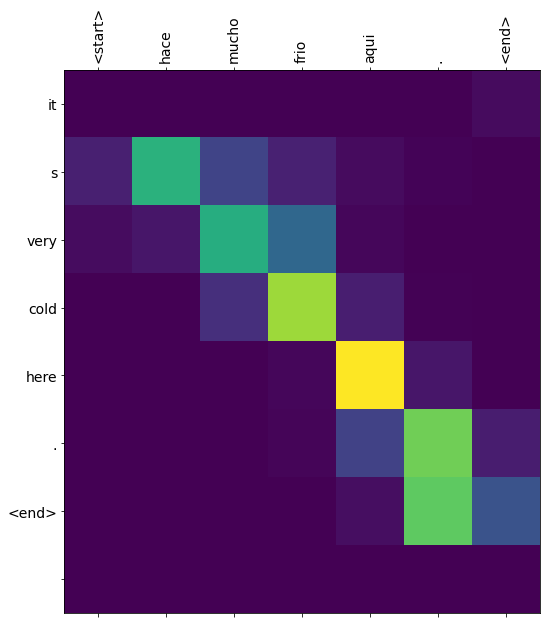

In [22]:
translate(u'hace mucho frio aqui.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still home ? <end> 
attention: [[6.62068587e-08 2.47933780e-08 1.59883416e-06 2.21478094e-05
  9.49876121e-05 2.46817013e-04 4.21969307e-04 3.66130448e-03]
 [4.93196659e-02 1.72590092e-01 3.65979671e-01 2.89863795e-01
  2.22617052e-02 5.33931516e-02 1.06403362e-02 5.33037074e-03]
 [1.10103935e-02 1.75075140e-03 8.62743855e-02 5.41734397e-01
  1.60997435e-01 1.68533430e-01 2.31946949e-02 2.28816480e-03]
 [3.16572748e-03 1.91932180e-04 7.34440284e-03 3.65624577e-02
  3.96508545e-01 4.29737389e-01 1.17541037e-01 5.51432837e-03]
 [1.25328488e-05 1.21754533e-06 9.94062357e-05 1.72473912e-04
  8.24575685e-03 6.61692768e-02 8.16466987e-01 1.00564972e-01]
 [3.78808772e-06 3.16633350e-06 1.32863221e-04 5.35423460e-04
  7.86582590e-04 1.78453897e-03 8.05904046e-02 8.43507826e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


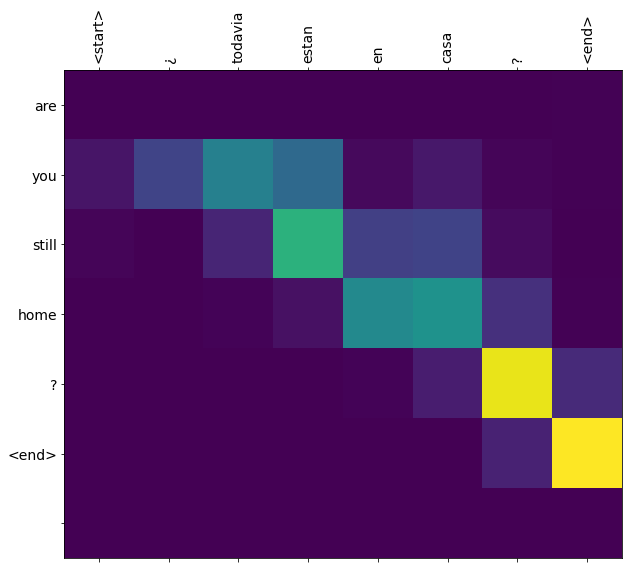

In [23]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it out . <end> 
attention: [[2.22983914e-07 3.39824766e-07 3.07997325e-05 2.54529179e-04
  4.26648767e-04 1.96011714e-03]
 [1.39340665e-02 1.30822882e-01 1.26960620e-01 6.70492828e-01
  5.37340380e-02 8.29963537e-04]
 [2.63865851e-03 3.13970516e-03 3.56183611e-02 2.83892035e-01
  6.48595154e-01 1.98222492e-02]
 [1.43608646e-04 4.01154830e-04 3.33824684e-03 4.42230068e-02
  8.74479771e-01 7.08262399e-02]
 [1.48866136e-04 7.90633436e-04 7.67326867e-03 3.82829756e-02
  6.68570817e-01 2.78350085e-01]
 [7.98678320e-06 1.58606141e-04 2.66589690e-03 8.29505827e-03
  1.93675324e-01 7.68196225e-01]
 [1.57832824e-06 1.91509862e-05 1.02077967e-04 2.80172448e-04
  2.19502649e-03 9.82447922e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


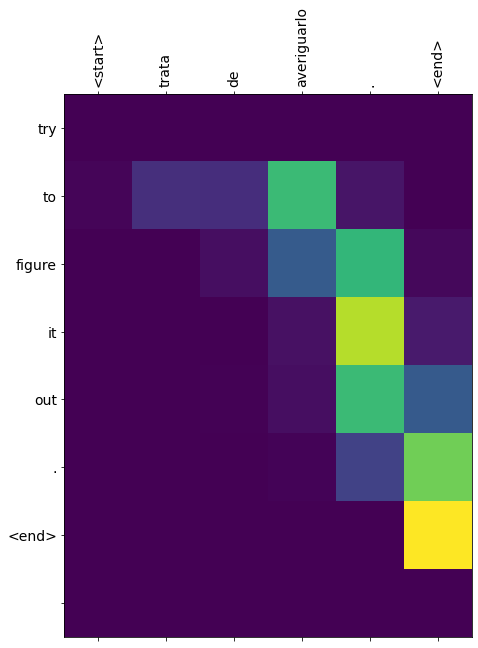

In [24]:
translate(u'trata de averiguarlo.')

Input: <start> hoy es un buen dia <end>
Predicted translation: today is a good day today . <end> 
attention: [[1.57010547e-08 2.77362460e-07 7.78438516e-06 9.03220207e-05
  3.97872762e-04 1.79320094e-04 5.42211579e-04]
 [1.16676703e-01 4.13557217e-02 5.58556318e-01 6.34799600e-02
  4.61940207e-02 4.71900739e-02 5.94654642e-02]
 [2.82278960e-03 6.30152877e-03 1.78579930e-02 3.68370324e-01
  3.67117971e-01 7.95012042e-02 5.62949590e-02]
 [4.32124252e-05 1.90695166e-04 3.93201946e-04 8.98599997e-03
  4.35277253e-01 4.99001175e-01 3.79688703e-02]
 [1.28970802e-04 4.33929090e-04 1.51772122e-03 3.34510650e-03
  1.09495841e-01 5.37094355e-01 2.97152698e-01]
 [2.74827789e-06 3.06475613e-06 8.27277108e-05 1.08714587e-04
  1.10065029e-03 2.74420017e-03 2.67940402e-01]
 [3.71537226e-06 1.14571376e-05 1.16156021e-04 3.46446264e-04
  2.33348971e-03 3.17954551e-03 2.77973771e-01]
 [2.84564953e-06 5.26602389e-06 1.60706855e-04 3.01673863e-04
  1.31143350e-03 2.24175490e-03 3.52491945e-01]
 [0.0000000

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


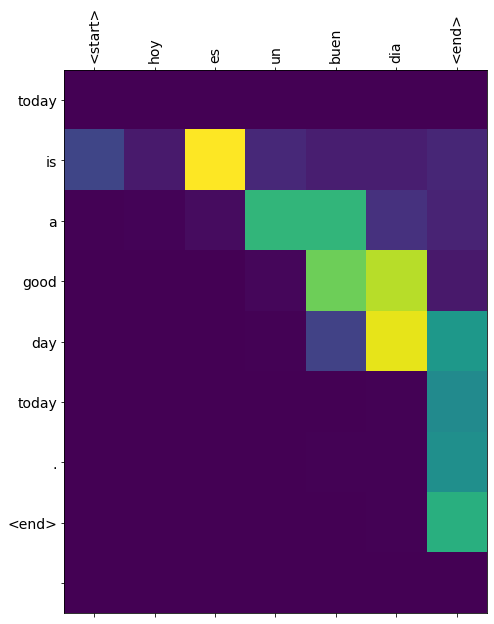

In [25]:
translate(u'Hoy es un buen día')